In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from scipy.io import arff

Running [KNeighborsClassifier] on [steel-plates-fault] Iteration: 50

Running [KNeighborsClassifier] on [ionosphere] Iteration: 50

Running [KNeighborsClassifier] on [banknotes] Iteration: 50

Running [GaussianNB] on [steel-plates-fault] Iteration: 50

Running [GaussianNB] on [ionosphere] Iteration: 50

Running [GaussianNB] on [banknotes] Iteration: 50

Running [DecisionTreeClassifier] on [steel-plates-fault] Iteration: 50

Running [DecisionTreeClassifier] on [ionosphere] Iteration: 50

Running [DecisionTreeClassifier] on [banknotes] Iteration: 50

Running [LogisticRegression] on [steel-plates-fault] Iteration: 50

Running [LogisticRegression] on [ionosphere] Iteration: 50

Running [LogisticRegression] on [banknotes] Iteration: 50

Running [GradientBoostingClassifier] on [steel-plates-fault] Iteration: 50

Running [GradientBoostingClassifier] on [ionosphere] Iteration: 50

Running [GradientBoostingClassifier] on [banknotes] Iteration: 50

Running [RandomForestClassifier] on [steel-plat

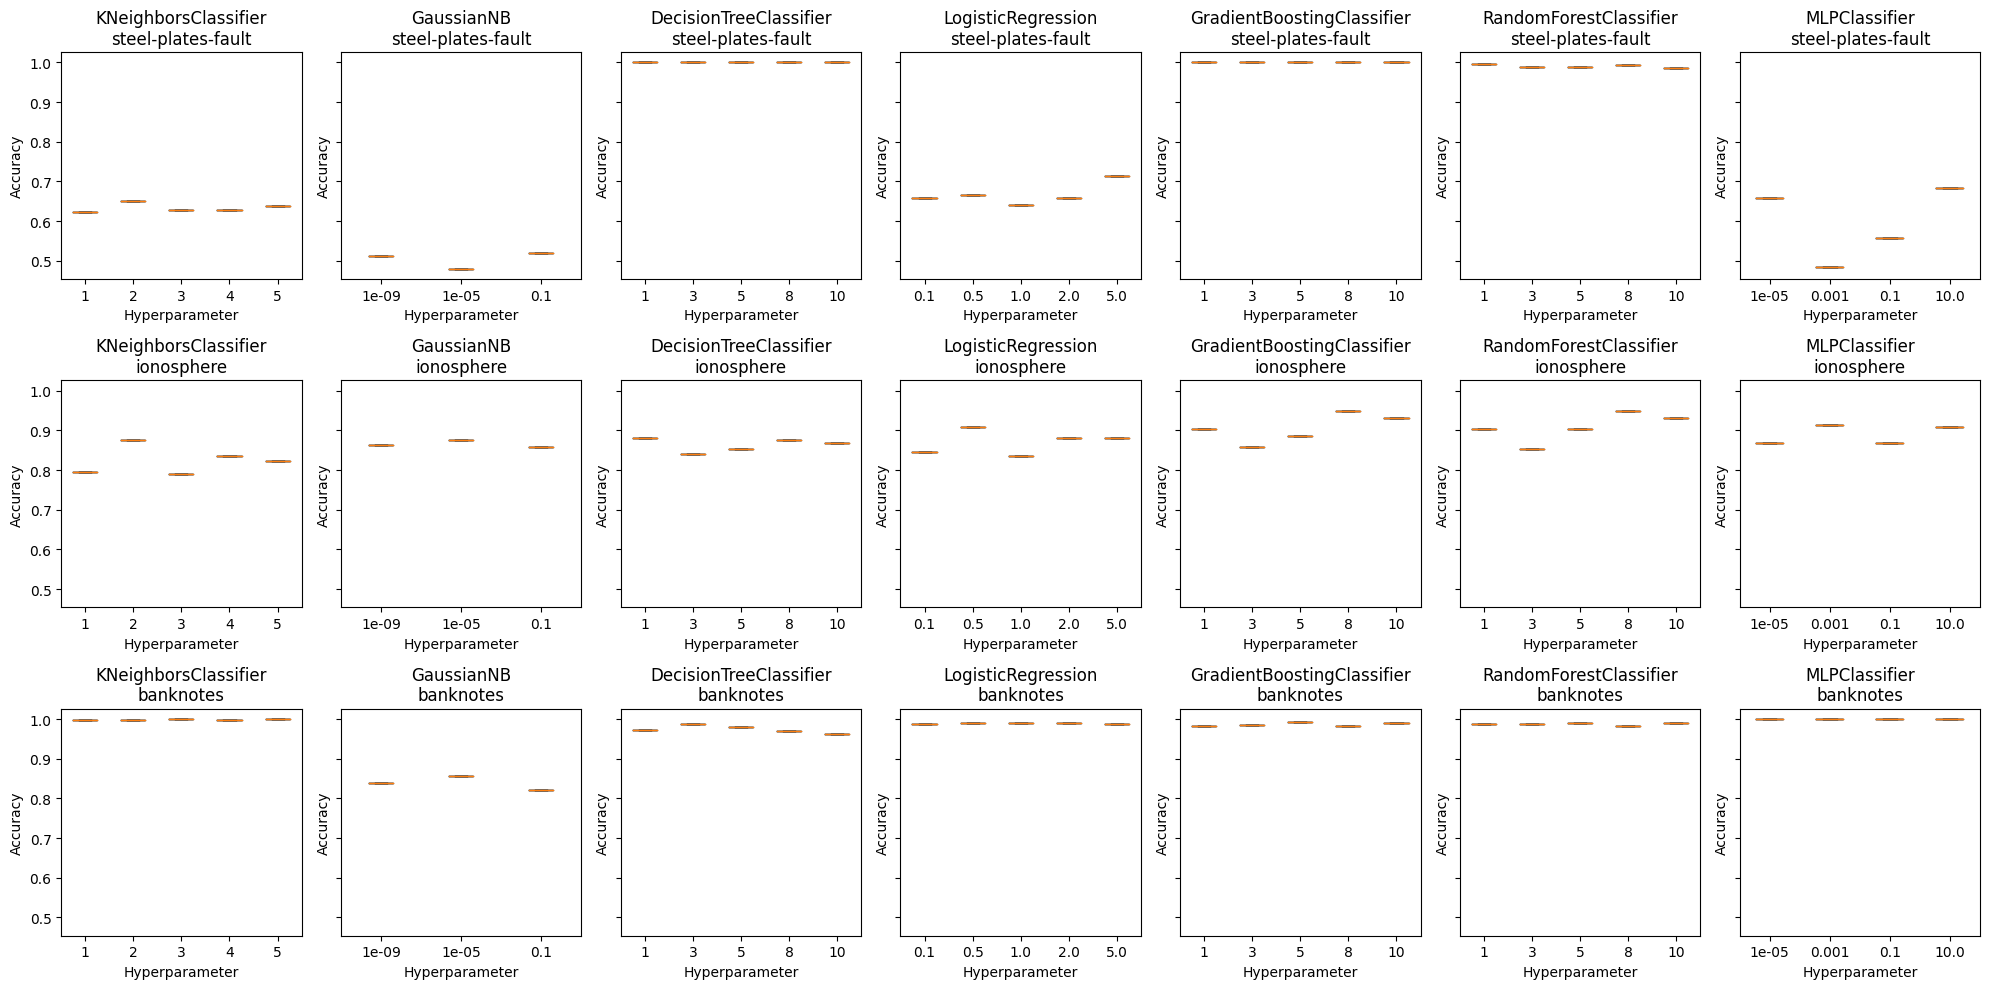

In [33]:
# Load .arff files and convert them to pandas DataFrames
def load_arff_to_dataframe(filename):
    data, meta = arff.loadarff(filename)
    df = pd.DataFrame(data)
    return df

# Read datasets and return features and target variables
def load_datasets():
    datasets = {
        'steel-plates-fault': 'steel-plates-fault.arff',
        'ionosphere': 'ionosphere.arff',
        'banknotes': 'banknotes.arff',
    }

    X = {}
    y = {}

    for dataset, filepath in datasets.items():
        df = load_arff_to_dataframe(filepath)
        X[dataset] = df.drop(columns=[df.columns[-1]]).values
        y[dataset] = LabelEncoder().fit_transform(df[df.columns[-1]])
    return X, y

# Define classifiers and their hyperparameters
classifiers = {
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'param_name': 'n_neighbors',
        'param_values': [1, 2, 3, 4, 5],
    },
    'GaussianNB': {
        'model': GaussianNB(),
        'param_name': 'var_smoothing',
        'param_values': [1e-9, 1e-5, 1e-1],
    },
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(),
        'param_name': 'max_depth',
        'param_values': [1, 3, 5, 8, 10],
    },
    'LogisticRegression': {
        'model': LogisticRegression(),
        'param_name': 'C',
        'param_values': [0.1, 0.5, 1.0, 2.0, 5.0],
    },
    'GradientBoostingClassifier': {
        'model': GradientBoostingClassifier(),
        'param_name': 'max_depth',
        'param_values': [1, 3, 5, 8, 10],
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'param_name': 'max_depth',
        'param_values': [1, 3, 5, 8, 10],
    },
    'MLPClassifier': {
        'model': MLPClassifier(),
        'param_name': 'alpha',
        'param_values': [1e-5, 1e-3, 0.1, 10.0],
    },
}

# Function to train and evaluate the model with given hyperparameters
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Function to repeat the evaluation with different random splits and track progress
def evaluate_model_multiple_times(model, X, y, clf_name, dataset_name):
    print(f"\rEvaluating {clf_name} on {dataset_name}", end="")
    accuracies = []
    for i in range(50):
        X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.5, random_state=i)
        accuracy = evaluate_model(model, X_train, X_test, y_train, y_test)
        accuracies.append(accuracy)
        print(
                "\r"
                + " "
                + "\r"
                + "Running ["
                + str(clf_name)
                + "] on ["
                + str(dataset_name)
                + "] Iteration: "
                + str(i+1),
                end="",
            )
    print("\n")
    return accuracies

def main():
    X, y = load_datasets()

    # Create an empty DataFrame to store the results
    results_table = pd.DataFrame(columns=['Classifier', 'Dataset', 'Hyperparameter', 'Accuracy'])

    for clf_name, clf_info in classifiers.items():
        model = clf_info['model']
        param_name = clf_info['param_name']
        param_values = clf_info['param_values']
        for dataset_name, X_data in X.items():
            clf_accuracies = evaluate_model_multiple_times(model, X_data, y[dataset_name], clf_name, dataset_name)
            for param_value, accuracy in zip(param_values, clf_accuracies):
                new_row = {
                    'Classifier': clf_name,
                    'Dataset': dataset_name,
                    'Hyperparameter': param_value,
                    'Accuracy': accuracy
                }
                results_table = pd.concat([results_table, pd.DataFrame([new_row])], ignore_index=True)

    # Create summary tables
    summary_table_1 = results_table.groupby(['Classifier', 'Dataset'])['Accuracy'].mean().reset_index()
    summary_table_2 = results_table.loc[results_table.groupby(['Classifier', 'Dataset'])['Accuracy'].idxmax()]

    print("Summary Table 1: Best mean value of the test errors")
    print(summary_table_1)

    print("\nSummary Table 2: Corresponding hyperparameter values for obtaining the best test errors")
    print(summary_table_2)

    # Plot box plots for each classifier-dataset combination
    fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(20, 10), sharey=True)
    for idx, (clf_name, clf_info) in enumerate(classifiers.items()):
        for jdx, dataset_name in enumerate(X.keys()):
            ax = axes[jdx, idx]
            data = results_table[(results_table['Classifier'] == clf_name) & (results_table['Dataset'] == dataset_name)]
            x_values = data['Hyperparameter'].unique()
            boxplot_data = [data[data['Hyperparameter'] == value]['Accuracy'] for value in x_values]
            ax.boxplot(boxplot_data)
            ax.set_xticklabels(x_values)
            ax.set_xticks(range(1, len(x_values) + 1))
            ax.set_title(f"{clf_name}\n{dataset_name}")
            ax.set_xlabel('Hyperparameter')
            ax.set_ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    import warnings
    warnings.filterwarnings("ignore")
    main()